<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content-dl/blob/fix_folder_names/tutorials/W1D2_LinearDeepLearning/W1D2_Tutorial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# DL Neuromatch Academy: Week 1, Day 2, Tutorial 1
# Gradients and AutoGrad

__Content creators:__ Saeed Salehi, Vladimir Haltakov, Andrew Saxe



__Content reviewers:__ Polina Turishcheva, Atnafu Lambebo, Yu-Fang Yang

__Content editors:__ Anoop Kulkarni

__Production editors:__ Khalid Almubarak, Spiros Chavlis

---
#Tutorial Objectives

Day 2 Tutorial 1 will continue on buiding PyTorch skillset and motivate its core functionality, Autograd. In this notebook, we will cover the key concepts and ideas of:

* Gradient descent
* PyTorch Autograd
* PyTorch nn module




In [1]:
#@markdown Tutorial slides
# you should link the slides for all tutorial videos here (we will store pdfs on osf)

from IPython.display import HTML
HTML('<iframe src="https://docs.google.com/presentation/d/1kfWWYhSIkczYfjebhMaqQILTCu7g94Q-o_ZcWb1QAKs/embed?start=false&loop=false&delayms=3000" frameborder="0" width="960" height="569" allowfullscreen="true" mozallowfullscreen="true" webkitallowfullscreen="true"></iframe>')

---
# Setup


In [2]:
# Imports

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import time
import random

from tqdm.notebook import tqdm, trange

In [3]:
#@title Figure settings

import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

In [4]:
#@title Plotting functions

def ex3_plot(epochs, losses, values, gradients):
  f, (plot1, plot2, plot3) = plt.subplots(3, 1, sharex=True, figsize=(10, 7))
  plot1.set_title("Cross Entropy Loss")
  plot1.plot(np.linspace(1, epochs, epochs), losses, color='r')

  plot2.set_title("First Parameter value")
  plot2.plot(np.linspace(1, epochs, epochs), values, color='c')

  plot3.set_title("First Parameter gradient")
  plot3.plot(np.linspace(1, epochs, epochs), gradients, color='m')
  plot3.set_xlabel("Epoch")
  plt.show()

In [5]:
#@title Helper functions

seed = 1943  # McCulloch & Pitts (1943)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

---
# Section 1: Gradient Descent Algorithm

Since the goal of most learning algorithms is **minimizing the risk (cost) function**, optimization is the soul of learning! The gradient descent algorithm, along with its variations such as stochastic gradient descent, is one of the most powerful and popular optimization methods used for deep learning.

## 1.1: Gradient Descent



Video available at https://youtu.be/PFQeUDxQFls


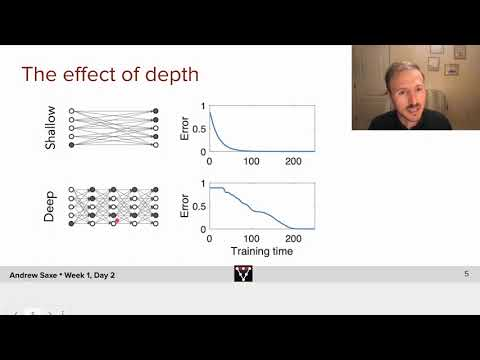

In [6]:
#@title Video 1.1: Introduction
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="PFQeUDxQFls", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

Video available at https://youtu.be/Z3dyRLR8GbM


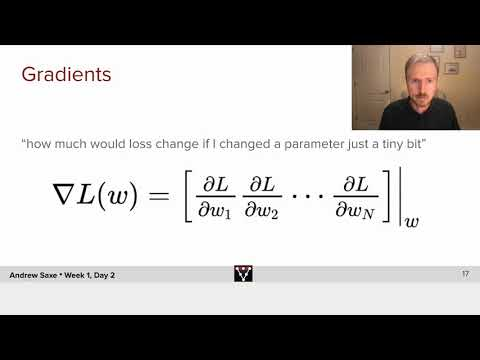

In [7]:
#@title Video 1.2: Gradient Descent
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="Z3dyRLR8GbM", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video


Gradient Descent (introduced by Augustin-Louis Cauchy in 1847) is an **iterative method** to **minimize** a **continuous** and (ideally) **differentiable function** of **many variables**.

### Definition
Let $f(\mathbf{w}): \mathbb{R}^d \rightarrow \mathbb{R}$ be a differentiable function. Gradient Descent is an iterative algorithm for minimizing the function $f$, starting with an initial value for variables $\mathbf{w}$, taking steps of size $\eta$ in the direction of the negative gradient at the current point to update the variables $\mathbf{w}$.

$$ \mathbf{w}^{(t+1)} = \mathbf{w}^{(t)} - \eta \nabla f (\mathbf{w}^{(t)}) $$

where $\eta > 0$ and $\nabla f (\mathbf{w})= \left( \frac{\delta f(\mathbf{w})}{\delta w_1}, ..., \frac{\delta f(\mathbf{w})}{\delta w_d} \right)$. Since negative gradients always point locally in the direction of steepest descent, the algorithm makes small steps at each point **towards** the minimum.
  
<br/>

### Vanilla Algorithm

---
> *inputs*: initial guess $\mathbf{w}^{(0)}$, step size $\eta > 0$, number of steps $T$

> *For* *t = 1, 2, ..., T* *do* \
$\qquad$ $\mathbf{w}^{(t+1)} = \mathbf{w}^{(t)} - \eta \nabla f (\mathbf{w}^{(t)})$\
*end*

> *return*: $\mathbf{w}^{(t+1)}$

---

<br/>

To be able to use this algorithm, we need to calculate the gradient of the loss with respect to the learnable parameters.


## 1.2: Calculating Gradients

To minimize the empirical risk (loss) function using gradient descent, we need to calculate the vector of partial derivatives:

$$\dfrac{\partial Loss}{\partial \mathbf{w}} = \left[ \dfrac{\partial Loss}{\partial w_1}, \dfrac{\partial Loss}{\partial w_2} , ..., \dfrac{\partial Loss}{\partial w_d} \right]^{\top} $$

Although PyTorch and other deep learning frameworks (e.g. JAX and TensorFlow) provide us with incredibly powerful and efficient algorithms for automatic differentiation, calculating few derivatives with hand would be fun.

### Exercise 1.2
1.  Given $L(w_1, w_2) = w_1^2 - 2w_1 w_2$ find $\dfrac{\partial L}{\partial w_1}$ and $\dfrac{\partial L}{\partial w_1}$.

<br/>

2.  Given $f(x) = sin(x)$ and $g(x) = \ln(x)$, find the derivative of their composite function $\dfrac{d (f \circ g)(x)}{d x}$ (*hint: chain rule*).

  **Chain rule**: For a composite function $F(x) = f(g(x)) \equiv (f \circ g)(x)$:
$$F'(x) = f'(g(x)) \cdot g'(x)$$
or differently denoted:
$$ \frac{dF}{dx} = \frac{df}{dg} ~ \frac{dg}{dx} $$

<br/>

3.  Given $f(x, y, z) = \tanh \left( \ln \left[1 + z \frac{2x}{sin(y)} \right] \right)$, how easy is it to derive $\dfrac{\partial f}{\partial x}$, $\dfrac{\partial f}{\partial y}$ and $\dfrac{\partial f}{\partial z}$? (*hint: you don't have to actually calculate them!*)


## 1.3: Computational Graphs and Backprop


Video available at https://youtu.be/7c8iCHcVgVs


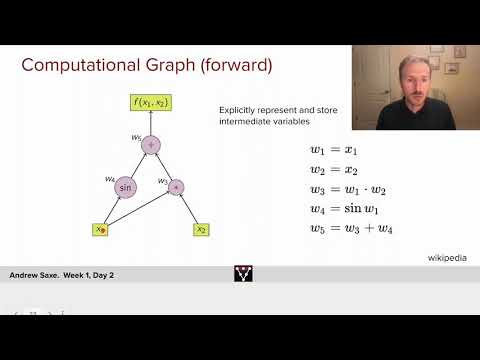

In [8]:
#@title Video 1.3: Computational Graph
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="7c8iCHcVgVs", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video


The last function in *Exercise 1.2* is an example of how overwhelming the derivation of gradients can get, as the number of variables and nested functions increases. This function is still extremely simple compared to the loss functions of modern neural networks. So how do PyTorch and similar frameworks approach such beasts?

### 1.3.1: Computational Graphs

Let’s look at the function again:

$$f(x, y, z) = \tanh \left(\ln \left[1 + z \frac{2x}{sin(y)} \right] \right)$$

we can build a so-called computational graph (shown below) to break the original function to smaller and more approachable expressions. If this "reverse engineering" approach seems unintuitive and arbitrary, it's because it is! Usually, the graph is built first.

<center><img src="https://raw.githubusercontent.com/ssnio/statics/main/neuromatch/comput_graph.png" alt="Computation Graph" width="800"/></center>

Starting from $x$, $y$, and $z$ and following the arrows and expressions, you would see that our graph returns the same function as $f$. It does so by calculating intermediate variables $a,b,c,d,$ and $e$. This is called the **forward pass**.

Now, let’s start from $f$, and work our way against the arrows while calculating the gradient of each expression as we go. This is called **backward pass**, which later inspires **backpropagation of errors**.

<center><img src="https://raw.githubusercontent.com/ssnio/statics/main/neuromatch/comput_graph_full.png" alt="Computation Graph full" width="1200"/></center>

Because we've split the computation into simple operations on intermediate variables, I hope you can appreciate how easy it now is to calculate the partial derivatives. 

Now we can use chain rule and simply calculate any gradient:

$$ \dfrac{\partial f}{\partial x} = \dfrac{\partial f}{\partial e}~\dfrac{\partial e}{\partial d}~\dfrac{\partial d}{\partial c}~\dfrac{\partial c}{\partial a}~\dfrac{\partial a}{\partial x} = \left( 1-\tanh^2(e) \right) \cdot \frac{1}{d}\cdot z \cdot \frac{1}{b} \cdot 2$$

Conveniently, the values for $e$, $b$, and $d$ are available to us from when we did the forward pass through the graph. That is, the partial derivatives have simple expressions in terms of the intermediate variables $a,b,c,d,e$ that we calculated and stored during the forward pass.


### Exercise 1.3
For the function above, calculate the $\dfrac{\partial f}{\partial y}$ and $\dfrac{\partial f}{\partial z}$ using the computational graph and chain rule.

For more: [Calculus on Computational Graphs: Backpropagation](https://colah.github.io/posts/2015-08-Backprop/)

---
# Section 2: PyTorch AutoGrad

Video available at https://youtu.be/h8B8Nlcz7yY


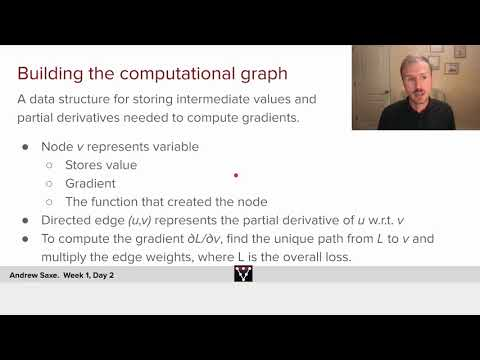

In [9]:
#@title Video 2.1: Automatic Differentiation
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="h8B8Nlcz7yY", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

Deep learning frameworks such as PyTorch, JAX, and TensorFlow come with a very efficient and sophisticated set of algorithms, commonly known as Automatic differentiation. AutoGrad is PyTorch's automatic differentiation engine. Here we start by covering the essentials of AutoGrad, but you will learn more in the coming days.



## Section 2.1: Forward Propagation

Everything starts with the forward propagation (pass). PyTorch plans the computational graph, as we declare the variables and operations, and it builds the graph when we call the backward pass. PyTorch rebuilds the graph every time we iterate or change it (or simply put, PyTorch uses a dynamic graph).

Before we start our first example, let's recall gradient descent algorithm. In gradient descent algorithm, it is only required to have the gradient of our cost function with respect to variables which are accessible to us for updating (changing). These variables are often called "learnable parameters" or simply parameter in PyTorch. In the case of neural networks, weights and biases are often the learnable parameters.

### Exercise 2.1

In PyTorch, we can set the optional argument `requires_grad` in tensors to `True`, so PyTorch would track every operation on them while configuring the computational graph. For this exercise, use the provided tensors to build the following graph.

<br/>

<center><img src="https://raw.githubusercontent.com/ssnio/statics/main/neuromatch/simple_graph.png" alt="Simple nn graph" width="600"/></center>

In [10]:
class SimpleGraph:
  def __init__(self, w=None, b=None):
    """Initializing the SimpleGraph

    Args:
      w (float): initial value for weight
      b (float): initial value for bias
    """
    if w is None:
      self.w = torch.randn(1, requires_grad=True)
    else:
      self.w = torch.tensor([w], requires_grad=True)
    if b is None:
      self.b = torch.randn(1, requires_grad=True)
    else:
      self.b = torch.tensor([b], requires_grad=True)

  def forward(self, x):
    """Forward pass

    Args:
      x (torch.Tensor): 1D tensor of features

    Returns:
      torch.Tensor: model predictions
    """
    assert isinstance(x, torch.Tensor)
    #################################################
    ## Implement the the forward pass to calculate prediction
    ## Note that prediction is not the loss, but the value after `tanh`
    # Complete the function and remove or comment the line below
    raise NotImplementedError("Forward Pass `forward`")
    #################################################
    prediction = ...
    return prediction


def sq_loss(y_true, y_prediction):
  """L2 loss function

  Args:
    y_true (torch.Tensor): 1D tensor of target labels
    y_true (torch.Tensor): 1D tensor of predictions

  Returns:
    torch.Tensor: L2-loss (squared error)
  """
  assert isinstance(y_true, torch.Tensor)
  assert isinstance(y_prediction, torch.Tensor)
  #################################################
  ## Implement the L2-loss (squred error) given true label and prediction
  # Complete the function and remove or comment the line below
  raise NotImplementedError("Loss function `sq_loss`")
  #################################################
  loss = ...
  return loss


# # Uncomment to run
# feature = torch.tensor([1])  # input tensor
# target = torch.tensor([7])  # target tensor

# simple_graph = SimpleGraph(-0.5, 0.5)
# print("initial weight = {} \ninitial bias = {}".format(simple_graph.w.item(),
#                                                         simple_graph.b.item()))

# prediction = simple_graph.forward(feature)
# square_loss = sq_loss(target, prediction)

# print("for x={} and y={}, prediction={} and L2 Loss = {}".format(feature.item(),
#                                                                  target.item(),
#                                                                  prediction.item(),
#                                                                  square_loss.item()))

In [11]:
# to_remove solution
class SimpleGraph:
  def __init__(self, w=None, b=None):
    """Initializing the SimpleGraph

    Args:
      w (float): initial value for weight
      b (float): initial value for bias
    """
    if w is None:
      self.w = torch.randn(1, requires_grad=True)
    else:
      self.w = torch.tensor([w], requires_grad=True)
    if b is None:
      self.b = torch.randn(1, requires_grad=True)
    else:
      self.b = torch.tensor([b], requires_grad=True)

  def forward(self, x):
    """Forward pass

    Args:
      x (torch.Tensor): 1D tensor of features

    Returns:
      torch.Tensor: model predictions
    """
    assert isinstance(x, torch.Tensor)
    prediction = torch.tanh(x * self.w + self.b)
    return prediction


def sq_loss(y_true, y_prediction):
  """L2 loss function

  Args:
    y_true (torch.Tensor): 1D tensor of target labels
    y_true (torch.Tensor): 1D tensor of predictions

  Returns:
    torch.Tensor: L2-loss (squared error)
  """
  assert isinstance(y_true, torch.Tensor)
  assert isinstance(y_prediction, torch.Tensor)
  loss = (y_true - y_prediction)**2
  return loss


feature = torch.tensor([1])  # input tensor
target = torch.tensor([7])  # target tensor

simple_graph = SimpleGraph(-0.5, 0.5)
print("initial weight = {} \ninitial bias = {}".format(simple_graph.w.item(),
                                                        simple_graph.b.item()))

prediction = simple_graph.forward(feature)
square_loss = sq_loss(target, prediction)

print("for x={} and y={}, prediction={} and L2 Loss = {}".format(feature.item(),
                                                                 target.item(),
                                                                 prediction.item(),
                                                                 square_loss.item()))

initial weight = -0.5 
initial bias = 0.5
for x=1 and y=7, prediction=0.0 and L2 Loss = 49.0


It is important to appreciate the fact that PyTorch can follow our operations as we arbitrary go through classes and functions.

## 2.2 Backward Propagation

Here is where all the magic lies. We can first look at the operations that PyTorch kept track of. Tensor property `grad_fn` keeps reference to backward propagation functions.

In [12]:
print('Gradient function for prediction =', prediction.grad_fn)
print('Gradient function for loss =', square_loss.grad_fn)

Gradient function for prediction = <TanhBackward object at 0x7fdf0f41cd10>
Gradient function for loss = <PowBackward0 object at 0x7fdf0f41c3d0>


Now let's kick off backward pass to calculate the gradients by calling the `.backward()` on the tensor we wish to initiate the backpropagation from. Often, `.backward()` is called on the loss, which is the last on the graph. Before doing that, let's calculate the loss gradients:

$$\frac{\partial{loss}}{\partial{w}} = - 2 x (y_t - y_p)(1 - y_p^2)$$

$$\frac{\partial{loss}}{\partial{b}} = - 2 (y_t - y_p)(1 - y_p^2)$$

We can then compare it to PyTorch gradients, which can be obtained by calling `.grad` on tensors.

**Important Notes**
* Always keep in mind that PyTorch is tracking all the operations for tensors that require grad. To stop this tracking, we use `.detach()`.

* PyTorch builds the graph only when `.backward()` is called and then it is set free. If you try calling `.backward()` after it is already called, you get the following error:

    *`Trying to backward through the graph a second time, but the saved intermediate results have already been freed. Specify retain_graph=True when calling .backward() or autograd.grad() the first time.`*

* Learnable parameters are "contagious". If you recall from our computational graph, we need all the intermediate gradients to be able to use the chain rule. Therefore, we need to `.detach()` any tensor that was on the path of gradient flow (e.g. prediction tensor).

* `.backward()` accumulates gradients in the leaves. For most of training methods, we call `.zero_grad()` on the loss or optimizer to zero `.grad` attributes (see [autograd.backward](https://pytorch.org/docs/stable/autograd.html#torch.autograd.backward) for more).

In [13]:
# analytical gradients (remember detaching)
ana_dloss_dw = - 2 * feature * (target - prediction.detach())*(1 - prediction.detach()**2)
ana_dloss_db = - 2 * (target - prediction.detach())*(1 - prediction.detach()**2)

square_loss.backward()  # first we should call the backward to build the graph
autograd_dloss_dw = simple_graph.w.grad
autograd_dloss_db = simple_graph.b.grad

print(ana_dloss_dw == autograd_dloss_dw)
print(ana_dloss_db == autograd_dloss_db)

tensor([True])
tensor([True])


References and more:
* [A GENTLE INTRODUCTION TO TORCH.AUTOGRAD](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html)

* [AUTOMATIC DIFFERENTIATION PACKAGE - TORCH.AUTOGRAD](https://pytorch.org/docs/stable/autograd.html)

* [AUTOGRAD MECHANICS](https://pytorch.org/docs/stable/notes/autograd.html)

* [AUTOMATIC DIFFERENTIATION WITH TORCH.AUTOGRAD](https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html)

---
# Section 3: PyTorch's Neural Net module (`nn.Module`)

Video available at https://youtu.be/rUChBWj9ihw


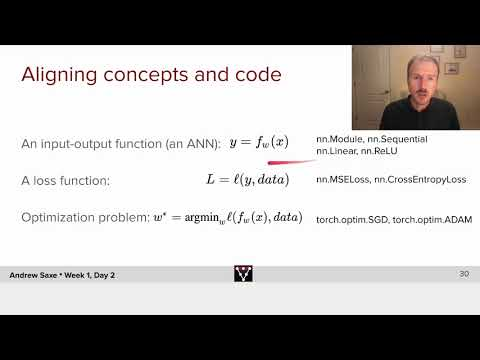

In [14]:
#@title Video 3.1: Putting it together
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="rUChBWj9ihw", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

In this section we will focus on training the simple neural network model from yesterday.

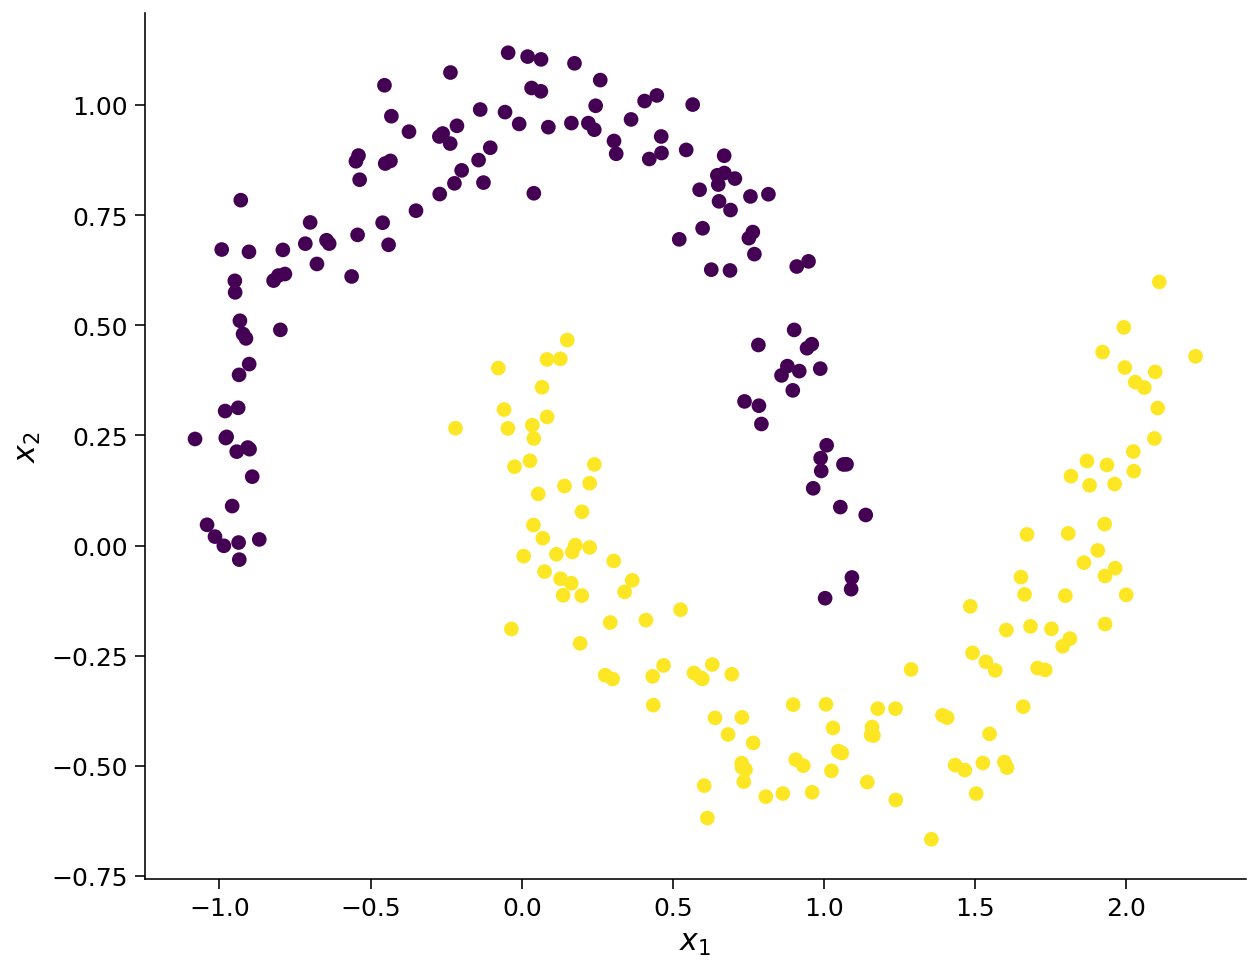

In [15]:
#@title Generate the sample dataset
import sklearn.datasets

# Create a dataset of 256 points with a little noise
X_orig, y_orig = sklearn.datasets.make_moons(256, noise=0.1)

# Plot the dataset
plt.figure(figsize=(9, 7))
plt.scatter(X_orig[:,0], X_orig[:,1], s=40, c=y_orig)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()

# Select the appropriate device (GPU or CPU)
device = "cuda" if torch.cuda.is_available() else "cpu"

# Convert the 2D points to a float tensor
X = torch.from_numpy(X_orig).type(torch.FloatTensor)
X = X.to(device)

# Convert the labels to a long interger tensor
y = torch.from_numpy(y_orig).type(torch.LongTensor)
y = y.to(device)

Let's define the same simple neural network model as in Day 1. This time we will not define a `train` method, but instead implement it outside of the class so we can better inspect it.

In [16]:
# Simple neural network with a single hidden layer
class NaiveNet(nn.Module):

  def __init__(self):
    """
    Initializing the NaiveNet
    """
    super(NaiveNet, self).__init__()
    self.layers = nn.Sequential(
        nn.Linear(2, 16),
        nn.ReLU(),
        nn.Linear(16, 2),
    )

  def forward(self, x):
    """Forward pass

    Args:
      x (torch.Tensor): 2D tensor of features

    Returns:
      torch.Tensor: model predictions
    """
    return self.layers(x)

PyTorch provides us with ready to use neural network building blocks, such as linear or recurrent layers, activation functions and loss functions, packed in the [`torch.nn`](https://pytorch.org/docs/stable/nn.html) module. If we build a neural network using the `torch.nn` layers, the weights and biases are already in `requires_grad` mode. 

Now let's prepare the training! We need 3 things for that:

*   **Model parameters** - Model parameters refer to all the learnable parameters' of the model which are accessible by calling `.parameters()` on the model. Please note that not all the `requires_grad` are seen as model parameters. To create a custom model parameter, you can use [`nn.Parameter`](https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html) (*A kind of Tensor that is to be considered a module parameter*). When we create a new instace of our model, layer parameters are initialized using a uniform distribution (more on that in the coming tutorials and days).

*   **Loss function** - we need to define the loss that we are going to be optimizing. The cross entropy loss is suitable for classification problems.

*   **Optimizer** - the optimizer will perform the adaptation of the model parameters according to the chosen loss function. The optimizer takes the parameters of the model (often by calling `.parameters()` on the model) as its input to be adapted.

You will learn more details about choosing the right loss function and optimizer later in the course.

In [17]:
# Create an instance of our network
naive_model = NaiveNet().to(device)

# Create a cross entropy loss function
cross_entropy_loss = nn.CrossEntropyLoss()

# Stochstic Gradient Descent optimizer with a learning rate of 1e-1
learning_rate = 1e-1
sgd_optimizer = torch.optim.SGD(naive_model.parameters(), lr=learning_rate)

The training process in PyTorch is interactive - you can perform training iterations as you wish and inspect the results after each iteration. We encourage leaving the loss function outside the explicit forward pass function, and rather calculate it on the output (prediction).

Let's perform one training iteration. You can run the cell multiple times and see how the parameters are being updated and the loss is reducing. We pick the parameters of the first neuron in the first layer. Please make sure you go through all the commands and discuss their purpose with the pod.

In [18]:
# Reset all gradients to 0
sgd_optimizer.zero_grad()

# Forward pass (Compute the output of the model on the data)
y_logits = naive_model(X)

# Compute the loss
loss = cross_entropy_loss(y_logits, y)
print('Loss:', loss.item())

# Perform backpropagation to build the graph and compute the gradients
loss.backward()

# `.parameters()` returns a generator
print('Gradients:', next(naive_model.parameters()).grad[0].detach().numpy())

# Print model's first learnable parameters
print('Parameters before:', next(naive_model.parameters())[0].detach().numpy())

# Optimizer takes a step in the steepest direction (negative of gradient)
# and "updates" the weights and biases of the network
sgd_optimizer.step()

# Print model's first learnable parameters
print('Parameters after: ', next(naive_model.parameters())[0].detach().numpy())

Loss: 0.7055032849311829
Gradients: [ 0.00316536 -0.00503508]
Parameters before: [-0.59306085  0.21870252]
Parameters after:  [-0.5933774   0.21920604]


## Exercise 3
Following everything we learned so far, we ask you to complete the `train` function below.

In [19]:
def train(features, labels, model, loss_fun, optimizer, n_epochs):

  """Training function

  Args:
    features (torch.Tensor): features (input) with shape torch.Size([n_samples, 2])
    labels (torch.Tensor): labels (targets) with shape torch.Size([n_samples, 2])
    model (torch nn.Module): the neural network
    loss_fun (function): loss function
    optimizer(function): optimizer
    n_epochs (int): number of training epochs

  Returns:
    list: record (evolution) of losses
    list: record (evolution) of value of the first parameter
    list: record (evolution) of gradient of the first parameter
  """
  loss_record = []  # keeping recods of loss
  par_values = []  # keeping recods of first parameter
  par_grads = []  # keeping recods of gradient of first parameter

  # we use `tqdm` methods for progress bar
  epoch_range = trange(n_epochs, desc='loss: ', leave=True)
  for i in epoch_range:

    if loss_record:
      epoch_range.set_description("loss: {:.4f}".format(loss_record[-1]))
      epoch_range.refresh()  # to show immediately the update
      time.sleep(0.01)

    #################################################
    ## Implement the missing parts of the training loop
    # Complete the function and remove or comment the line below
    raise NotImplementedError("Training setup `train`")
    #################################################
    ...  # Initialize gradients to 0
    predictions = ...  # Compute model prediction (output)
    loss = ...  # Compute the loss
    ...  # Compute gradients (backward pass)
    ...  # update parameters (optimizer takes a step)

    loss_record.append(loss.item())
    par_values.append(next(model.parameters())[0][0].item())
    par_grads.append(next(model.parameters()).grad[0][0].item())

  return loss_record, par_values, par_grads

# # Uncomment to run
# epochs = 5000
# losses, values, gradients = train(X, y,
#                                   naive_model,
#                                   cross_entropy_loss,
#                                   sgd_optimizer,
#                                   epochs)

# ex3_plot(epochs, losses, values, gradients)

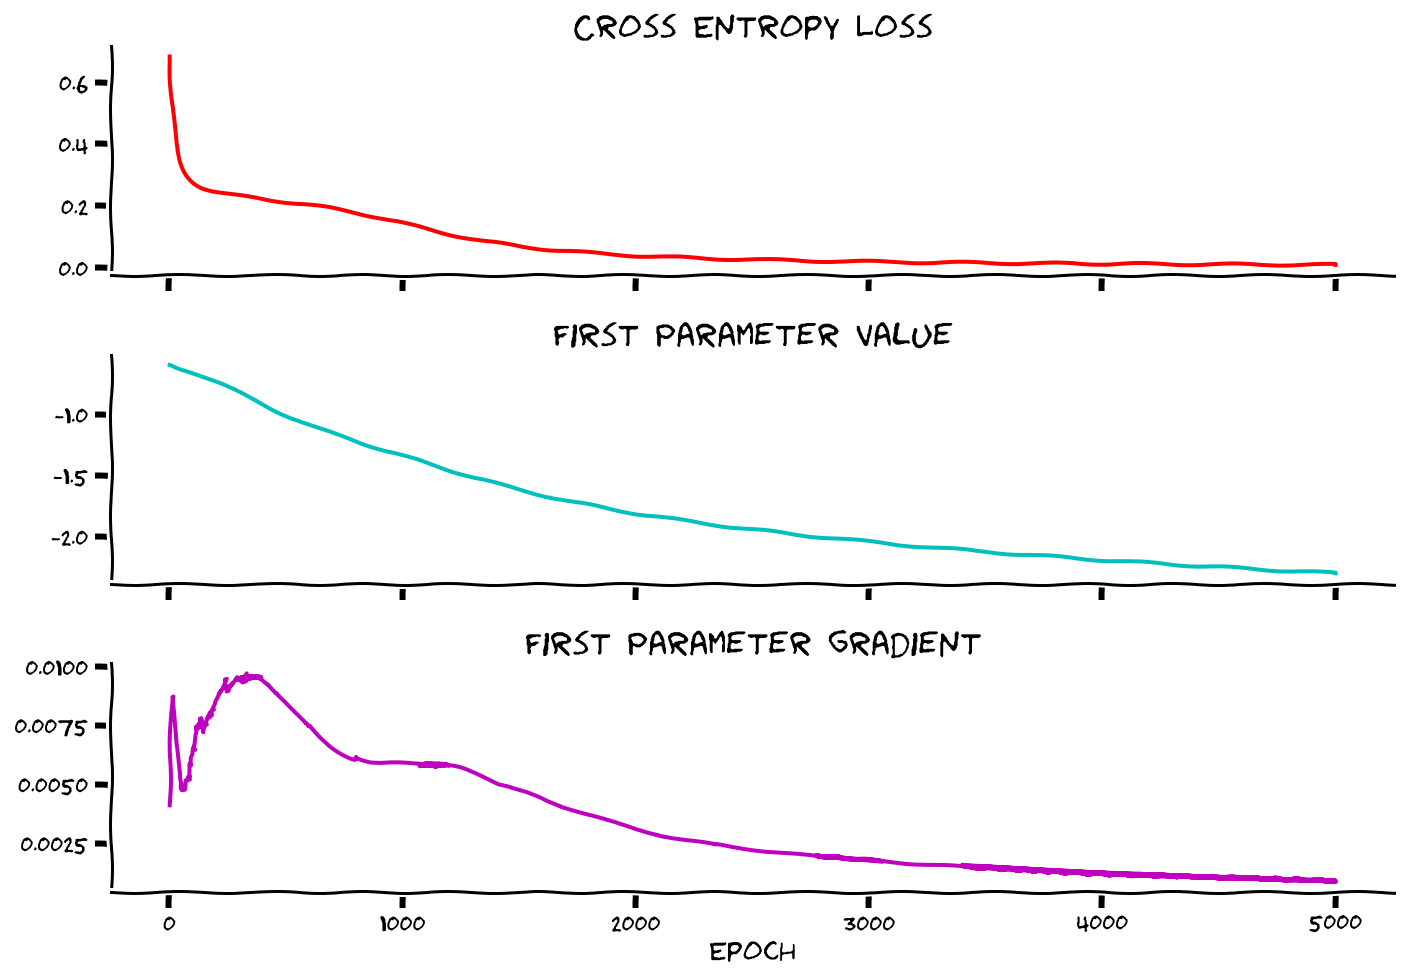

In [20]:
# to_remove solution
def train(features, labels, model, loss_fun, optimizer, n_epochs):

  """Training function

  Args:
    features (torch.Tensor): features (input) with shape torch.Size([n_samples, 2])
    labels (torch.Tensor): labels (targets) with shape torch.Size([n_samples, 2])
    model (torch nn.Module): the neural network
    loss_fun (function): loss function
    optimizer(function): optimizer
    n_epochs (int): number of training epochs

  Returns:
    list: record (evolution) of losses
    list: record (evolution) of value of the first parameter
    list: record (evolution) of gradient of the first parameter
  """
  loss_record = []  # keeping recods of loss
  par_values = []  # keeping recods of first parameter
  par_grads = []  # keeping recods of gradient of first parameter

  # we use `tqdm` methods for progress bar
  epoch_range = trange(n_epochs, desc='loss: ', leave=True)
  for i in epoch_range:

    if loss_record:
      epoch_range.set_description("loss: {:.4f}".format(loss_record[-1]))
      epoch_range.refresh()  # to show immediately the update
      time.sleep(0.01)

    optimizer.zero_grad()  # Initialize gradients to 0
    predictions = model(features)  # Compute model prediction (output)
    loss = loss_fun(predictions, labels)  # Compute the loss
    loss.backward()  # Compute gradients (backward pass)
    optimizer.step()  # update parameters (optimizer takes a step)

    loss_record.append(loss.item())
    par_values.append(next(model.parameters())[0][0].item())
    par_grads.append(next(model.parameters()).grad[0][0].item())

  return loss_record, par_values, par_grads


epochs = 5000
losses, values, gradients = train(X, y,
                                  naive_model,
                                  cross_entropy_loss,
                                  sgd_optimizer,
                                  epochs)

with plt.xkcd():
  ex3_plot(epochs, losses, values, gradients)

Video available at https://youtu.be/zFmWs6doqhM


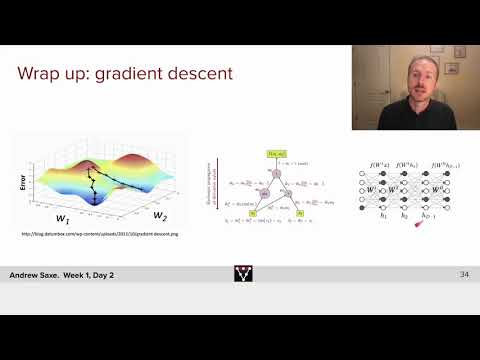

In [21]:
#@title Video 3.2: Wrap-up
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="zFmWs6doqhM", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video